In [1]:
import numpy as np
import gensim.downloader as api #For downloading pre-trained word embeddings
from scipy.stats import spearmanr
import os
from cuml.manifold import TSNE # GPU-accelerated t-SNE from RAPIDS cuML
import cudf # GPU DataFrame library
import numpy as np
import cupy as cp  #  GPU-accelerated version of NumPy

In [2]:
# Load the pre-trained FastText model
def load_fasttext_model():
    """Loads the pre-trained FastText model from Gensim's API."""
    os.environ["GENSIM_DATA_DIR"] = "/teamspace/studios/this_studio/gensim-data"  # Set Gensim's data directory
    fasttext_model = api.load('fasttext-wiki-news-subwords-300')  # Load FastText model
    return fasttext_model
    
import time

def tsne_dimensionality_reduction(embeddings, target_dim, perplexity, learning_rate=200):
    """
    Reduces dimensions of embeddings using GPU-accelerated t-SNE.

    Parameters:
        embeddings (numpy.ndarray): Input high-dimensional embeddings (e.g., FastText) as a NumPy array.
        target_dim (int): Number of dimensions for the reduced space. Default is 2.
        perplexity (float): t-SNE perplexity parameter. Default is 30.
        learning_rate (float): Learning rate for optimization. Default is 200.

    Returns:
        numpy.ndarray: Reduced dimensionality embeddings.
    """
    print(f"Loading embeddings into GPU memory and initializing t-SNE with {target_dim} dimensions...")

    # Convert embeddings to a GPU DataFrame (cudf)
    embeddings_gpu = cudf.DataFrame.from_records(embeddings)

    # Initialize GPU-accelerated t-SNE
    tsne = TSNE(
        n_components=target_dim,
        perplexity=perplexity,
        learning_rate=learning_rate,
        random_state=42,  # For reproducibility
        verbose=1         # Enables progress output
    )

    print("Starting t-SNE dimensionality reduction...")
    start_time = time.time()  # Start timing

    # Perform dimensionality reduction
    reduced_embeddings = tsne.fit_transform(embeddings_gpu)

    end_time = time.time()  # End timing
    elapsed_time = end_time - start_time
    print(f"t-SNE completed in {elapsed_time:.2f} seconds.")

    return reduced_embeddings.to_pandas().to_numpy()  # Convert back to NumPy array if needed

# Load the SimLex-999 dataset, which contains word pairs with human-annotated similarity scores 
# for benchmarking.
def load_simlex_999(file_path):
    """Loads SimLex-999 and returns word pairs with similarity scores."""
    data = []
    with open(file_path, 'r') as file:
        next(file)  # Skip the header
        for line in file:
            parts = line.strip().split('\t')
            word1, word2, similarity_score = parts[0], parts[1], float(parts[3])
            data.append((word1, word2, similarity_score))
    return data

# Calculate cosine similarity between word vectors 
def cosine_similarity(v1, v2):
    """Calculates cosine similarity between two vectors."""
    norm1 = np.linalg.norm(v1)
    norm2 = np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return 0
    return np.dot(v1, v2) / (norm1 * norm2)

# evaluate the embedding model's performance using Spearman correlation 
# against human judgments from SimLex-999.
def evaluate_embeddings(model, word_pairs):
    """Evaluates embeddings using SimLex-999 data and Spearman correlation."""
    predicted_scores = []
    true_scores = []

    for word1, word2, true_score in word_pairs:
        if word1 in model and word2 in model:
            sim_score = cosine_similarity(model[word1], model[word2])
            predicted_scores.append(sim_score)
            true_scores.append(true_score)

    # Calculate Spearman correlation for word similarity performance
    correlation, _ = spearmanr(true_scores, predicted_scores)
    return correlation

In [3]:
glove_file_path = '/teamspace/uploads/glove.6B.300d.txt'  # Update this path to your GloVe file
simlex_file_path = '/teamspace/studios/pca/SimLex-999.txt'  # Update this path to your SimLex-999 file
target_dim = 2  # Adjust target_dim as needed for testing (e.g., 150, 100, 50)

In [4]:
print("Loading FastText model...")
original_model = load_fasttext_model()

Loading FastText model...


In [5]:
word_pairs = load_simlex_999(simlex_file_path)

In [6]:
# Initialize a dictionary to store results for each perplexity value
results = {}
best_result = -100.0
optimized_embeddings1 = None

# List of perplexity values to evaluate
perplexities = [
5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
# Perform t-SNE and evaluate embeddings for each perplexity value
for perplexity in perplexities:
    print(f"\nPerforming t-SNE with perplexity={perplexity}...")
    
    # Perform t-SNE dimensionality reduction
    reduced_embeddings = tsne_dimensionality_reduction(original_model.vectors, target_dim=2, perplexity=perplexity, learning_rate=200)
    
    # Create a dictionary with the reduced embeddings for evaluation
    reduced_model = {word: reduced_embeddings[i] for i, word in enumerate(original_model.index_to_key)} #maps words to their reduced 2D embeddings    
   
    # Evaluate the reduced embeddings on SimLex-999
    correlation = evaluate_embeddings(reduced_model, word_pairs)
    
    # Store results
    results[perplexity] = correlation

    if(correlation > best_result):
        best_result = correlation
        optimized_embeddings1 = reduced_embeddings
    
    # Print Spearman correlation for the current perplexity
    print(f"Spearman Correlation for perplexity={perplexity}: {correlation:.4f}")

# Print a summary of all results
print("\nSummary of Spearman correlations across perplexities:")
for perplexity, correlation in results.items():
    print(f"Perplexity={perplexity}: Spearman Correlation={correlation:.4f}")

print("BEST Spearman Correlation = ", best_result)


Performing t-SNE with perplexity=5...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 241.01 seconds.
Spearman Correlation for perplexity=5: -0.0016

Performing t-SNE with perplexity=15...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 243.66 seconds.
Spearman Correlation for perplexity=15: 0.0287

Performing t-SNE with perplexity=25...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 248.08 seconds.
Spearman Correlation for perplexity=25: 0.0415

Performing t-SNE with perplexity=35...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 252.02 seconds.
Spearman Correlation for perplexity=35: 0.1122

Performing t-SNE with perplexity=45...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 252.20 seconds.
Spearman Correlation for perplexity=45: 0.0717

Performing t-SNE with perplexity=55...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 251.42 seconds.
Spearman Correlation for perplexity=55: 0.0203

Performing t-SNE with perplexity=65...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 252.32 seconds.
Spearman Correlation for perplexity=65: 0.0740

Performing t-SNE with perplexity=75...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 247.99 seconds.
Spearman Correlation for perplexity=75: 0.0653

Performing t-SNE with perplexity=85...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 250.02 seconds.
Spearman Correlation for perplexity=85: 0.1330

Performing t-SNE with perplexity=95...
Loading embeddings into GPU memory and initializing t-SNE with 2 dimensions...


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


Starting t-SNE dimensionality reduction...
t-SNE completed in 251.62 seconds.
Spearman Correlation for perplexity=95: 0.0106

Summary of Spearman correlations across perplexities:
Perplexity=5: Spearman Correlation=-0.0016
Perplexity=15: Spearman Correlation=0.0287
Perplexity=25: Spearman Correlation=0.0415
Perplexity=35: Spearman Correlation=0.1122
Perplexity=45: Spearman Correlation=0.0717
Perplexity=55: Spearman Correlation=0.0203
Perplexity=65: Spearman Correlation=0.0740
Perplexity=75: Spearman Correlation=0.0653
Perplexity=85: Spearman Correlation=0.1330
Perplexity=95: Spearman Correlation=0.0106
BEST Spearman Correlation =  0.1330452115847713


In [10]:
import pandas as pd
# Save the 2D embeddings with word labels to a CSV file
def save_embeddings_to_csv(words, embeddings, file_path):
    print(f"Saving 2D embeddings to {file_path}...")
    df = pd.DataFrame(embeddings, columns=['x', 'y'])
    df['word'] = words
    df.to_csv(file_path, index=False)
    print("2D embeddings saved successfully.")

In [11]:
# Get words and their high-dimensional embeddings
words = original_model.index_to_key  # List of words in vocabulary
######### RENAME AS PER THE BEST RESULT
file_path="FastText_TSNE_2d_word_embeddings_1330.csv"
# Save the embeddings and words to a CSV file
######### UPDATE THE optimized_embeddings variable as per the best result
save_embeddings_to_csv(words, optimized_embeddings1, file_path)

Saving 2D embeddings to FastText_TSNE_2d_word_embeddings_1330.csv...


2D embeddings saved successfully.


In [ ]:
# Initialize a dictionary to store results for each perplexity value
results = {}
best_result = -100.0
optimized_embeddings2 = None

# List of perplexity values to evaluate
perplexities = [
5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
# Perform t-SNE and evaluate embeddings for each perplexity value
for perplexity in perplexities:
    print(f"\nPerforming t-SNE with perplexity={perplexity}...")
    
    # Perform t-SNE dimensionality reduction
    reduced_embeddings = tsne_dimensionality_reduction(original_model.vectors, target_dim=2, perplexity=perplexity, learning_rate=200)
    
    # Create a dictionary with the reduced embeddings for evaluation
    reduced_model = {word: reduced_embeddings[i] for i, word in enumerate(original_model.index_to_key)}
    
    # Evaluate the reduced embeddings on SimLex-999
    correlation = evaluate_embeddings(reduced_model, word_pairs)
    
    # Store results
    results[perplexity] = correlation

    if(correlation > best_result):
        best_result = correlation
        optimized_embeddings2 = reduced_embeddings
    
    # Print Spearman correlation for the current perplexity
    print(f"Spearman Correlation for perplexity={perplexity}: {correlation:.4f}")

# Print a summary of all results
print("\nSummary of Spearman correlations across perplexities:")
for perplexity, correlation in results.items():
    print(f"Perplexity={perplexity}: Spearman Correlation={correlation:.4f}")

print("BEST Spearman Correlation = ", best_result)

In [ ]:
# Initialize a dictionary to store results for each perplexity value
results = {}
best_result = -100.0
optimized_embeddings3 = None

# List of perplexity values to evaluate
perplexities = [
5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
# Perform t-SNE and evaluate embeddings for each perplexity value
for perplexity in perplexities:
    print(f"\nPerforming t-SNE with perplexity={perplexity}...")
    
    # Perform t-SNE dimensionality reduction
    reduced_embeddings = tsne_dimensionality_reduction(original_model.vectors, target_dim=2, perplexity=perplexity, learning_rate=200)
    
    # Create a dictionary with the reduced embeddings for evaluation
    reduced_model = {word: reduced_embeddings[i] for i, word in enumerate(original_model.index_to_key)}
    
    # Evaluate the reduced embeddings on SimLex-999
    correlation = evaluate_embeddings(reduced_model, word_pairs)
    
    # Store results
    results[perplexity] = correlation

    if(correlation > best_result):
        best_result = correlation
        optimized_embeddings3 = reduced_embeddings
    
    # Print Spearman correlation for the current perplexity
    print(f"Spearman Correlation for perplexity={perplexity}: {correlation:.4f}")

# Print a summary of all results
print("\nSummary of Spearman correlations across perplexities:")
for perplexity, correlation in results.items():
    print(f"Perplexity={perplexity}: Spearman Correlation={correlation:.4f}")

print("BEST Spearman Correlation = ", best_result)

In [ ]:
# Initialize a dictionary to store results for each perplexity value
results = {}
best_result = -100.0
optimized_embeddings4 = None

# List of perplexity values to evaluate
perplexities = [
5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
# Perform t-SNE and evaluate embeddings for each perplexity value
for perplexity in perplexities:
    print(f"\nPerforming t-SNE with perplexity={perplexity}...")
    
    # Perform t-SNE dimensionality reduction
    reduced_embeddings = tsne_dimensionality_reduction(original_model.vectors, target_dim=2, perplexity=perplexity, learning_rate=200)
    
    # Create a dictionary with the reduced embeddings for evaluation
    reduced_model = {word: reduced_embeddings[i] for i, word in enumerate(original_model.index_to_key)}
    
    # Evaluate the reduced embeddings on SimLex-999
    correlation = evaluate_embeddings(reduced_model, word_pairs)
    
    # Store results
    results[perplexity] = correlation

    if(correlation > best_result):
        best_result = correlation
        optimized_embeddings4 = reduced_embeddings
    
    # Print Spearman correlation for the current perplexity
    print(f"Spearman Correlation for perplexity={perplexity}: {correlation:.4f}")

# Print a summary of all results
print("\nSummary of Spearman correlations across perplexities:")
for perplexity, correlation in results.items():
    print(f"Perplexity={perplexity}: Spearman Correlation={correlation:.4f}")

print("BEST Spearman Correlation = ", best_result)

In [ ]:
# Initialize a dictionary to store results for each perplexity value
results = {}
best_result = -100.0
optimized_embeddings5 = None

# List of perplexity values to evaluate
perplexities = [
5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
# Perform t-SNE and evaluate embeddings for each perplexity value
for perplexity in perplexities:
    print(f"\nPerforming t-SNE with perplexity={perplexity}...")
    
    # Perform t-SNE dimensionality reduction
    reduced_embeddings = tsne_dimensionality_reduction(original_model.vectors, target_dim=2, perplexity=perplexity, learning_rate=200)
    
    # Create a dictionary with the reduced embeddings for evaluation
    reduced_model = {word: reduced_embeddings[i] for i, word in enumerate(original_model.index_to_key)}
    
    # Evaluate the reduced embeddings on SimLex-999
    correlation = evaluate_embeddings(reduced_model, word_pairs)
    
    # Store results
    results[perplexity] = correlation

    if(correlation > best_result):
        best_result = correlation
        optimized_embeddings5 = reduced_embeddings
    
    # Print Spearman correlation for the current perplexity
    print(f"Spearman Correlation for perplexity={perplexity}: {correlation:.4f}")

# Print a summary of all results
print("\nSummary of Spearman correlations across perplexities:")
for perplexity, correlation in results.items():
    print(f"Perplexity={perplexity}: Spearman Correlation={correlation:.4f}")

print("BEST Spearman Correlation = ", best_result)

In [ ]:
# Save the 2D embeddings with word labels to a CSV file
def save_embeddings_to_csv(words, embeddings, file_path):
    print(f"Saving 2D embeddings to {file_path}...")
    df = pd.DataFrame(embeddings, columns=['x', 'y'])
    df['word'] = words
    df.to_csv(file_path, index=False)
    print("2D embeddings saved successfully.")

In [ ]:
# Get words and their high-dimensional embeddings
words = original_model.index_to_key  # List of words in vocabulary
######### RENAME AS PER THE BEST RESULT
file_path="FastText_TSNE_2d_word_embeddings_1234.csv"
# Save the embeddings and words to a CSV file
######### UPDATE THE optimized_embeddings variable as per the best result
save_embeddings_to_csv(words, optimized_embeddings, file_path)

In [11]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity

# Load SimLex-999 data
def load_simlex_999(filepath):
    """Loads the SimLex-999 dataset."""
    word_pairs = []
    with open(filepath, 'r') as f:
        next(f)  # Skip the header line
        for line in f:
            parts = line.strip().split('\t')
            word1, word2, simlex_score = parts[0], parts[1], float(parts[3])
            word_pairs.append((word1, word2, simlex_score))
    return word_pairs

# Evaluate embeddings on the SimLex-999 data
def evaluate_embeddings(model, word_pairs):
    """Evaluates embeddings using SimLex-999 data and Spearman correlation."""
    predicted_scores = []
    true_scores = []

    for word1, word2, true_score in word_pairs:
        if word1 in model and word2 in model:
            sim_score = cosine_similarity(model[word1].reshape(1, -1), model[word2].reshape(1, -1))[0][0]
            predicted_scores.append(sim_score)
            true_scores.append(true_score)

    # Calculate Spearman correlation for word similarity performance
    correlation, _ = spearmanr(true_scores, predicted_scores)
    return correlation

# Path to your CSV file containing embeddings
embeddings_csv_path = '/teamspace/studios/this_studio/Glove_TSNE_2d_word_embeddings_1659.csv'  # Update this with your actual file path

# Load embeddings from CSV
def load_embeddings_from_csv(filepath):
    """Loads word embeddings from a CSV file into a dictionary."""
    df = pd.read_csv(filepath)
    model = {}
    for index, row in df.iterrows():
        word = row['word']
        embedding = np.array([row['x'], row['y']], dtype=np.float32)
        model[word] = embedding
    return model

# Load the embeddings
model = load_embeddings_from_csv(embeddings_csv_path)

# Load SimLex-999 word pairs
simlex_file_path = '/teamspace/studios/pca/SimLex-999.txt'  # Update this path to your SimLex-999 file
word_pairs = load_simlex_999(simlex_file_path)

# Evaluate the embeddings
correlation = evaluate_embeddings(model, word_pairs)
print(f"Spearman correlation on SimLex-999: {correlation}")

Spearman correlation on SimLex-999: 0.16588006435171007


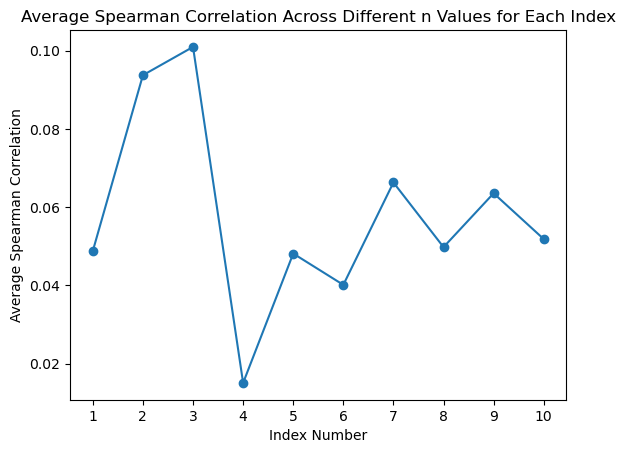

In [1]:
import matplotlib.pyplot as plt

# spearman_correlations_n5 = [0.2166, 0.1728, 0.1662, 0.2061, 0.2228, 0.1463, 0.2007, 0.1542, 0.2303, 0.1846]
# spearman_correlations_n10 = [0.2162, 0.2117, 0.2200, 0.1586, 0.1735, 0.1282, 0.1075, 0.1819, 0.1434, 0.1709]
# spearman_correlations_n15 = [0.2391, 0.2319, 0.1743, 0.1967, 0.2112, 0.2084, 0.1760, 0.1957, 0.1889, 0.1718]
# spearman_correlations_n20 = [0.2467, 0.2074, 0.1986, 0.2203, 0.1701, 0.1653, 0.1956, 0.1588, 0.1410, 0.1697]
# spearman_correlations_n25 = [0.2103, 0.2334, 0.2004, 0.1760, 0.2004, 0.2021, 0.1766, 0.2071, 0.1895, 0.1689]

spearman_correlations_list1 = [0.0016, 0.0287, 0.0415, 0.1122, 0.0717, 0.0203, 0.0740, 0.0653, 0.1330, 0.0106]
spearman_correlations_list2 = [0.0502, 0.0861, 0.0880, -0.0071, 0.0831, 0.1335, 0.0895, 0.1028, 0.0355, 0.0690]
spearman_correlations_list3 = [0.0966, 0.0490, 0.1057, 0.0159, 0.0411, -0.0061, 0.1000, 0.0258, -0.0322, 0.1102]
spearman_correlations_list4 = [0.0562, 0.1415, 0.1595, 0.0171, -0.0006, 0.0439, 0.0401, 0.0275, 0.1317, 0.0080]
spearman_correlations_list5 = [0.0395, 0.1634, 0.1101, -0.0626, 0.0455, 0.0092, 0.0280, 0.0276, 0.0498, 0.0615]

# Combine all lists into a single list of lists
# all_lists = [
#     spearman_correlations_n5,
#     spearman_correlations_n10,
#     spearman_correlations_n15,
#     spearman_correlations_n20,
#     spearman_correlations_n25,
# ]
all_lists = [
    spearman_correlations_list1,
    spearman_correlations_list2,
    spearman_correlations_list3,
    spearman_correlations_list4,
    spearman_correlations_list5,
]

# Calculate the average value for each index across all lists
index_averages = []
for i in range(len(spearman_correlations_list1)):  # Iterate through indices (0 to 9)
    index_values = [lst[i] for lst in all_lists]  # Get the value at index i from each list
    index_average = sum(index_values) / len(index_values)
    index_averages.append(index_average)

# Create a list of index numbers for the x-axis
index_numbers = list(range(1, len(spearman_correlations_list1) + 1))  # 1 to 10

# Plot the index averages in a line graph
plt.plot(index_numbers, index_averages, marker='o')

# Add labels and title
plt.xlabel("Index Number")
plt.ylabel("Average Spearman Correlation")
plt.title("Average Spearman Correlation Across Different n Values for Each Index")

# Customize the x-axis ticks
plt.xticks(index_numbers)

# Display the plot
plt.show()

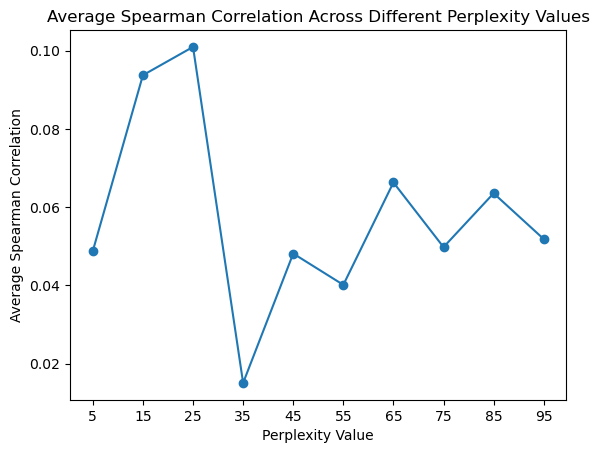

In [1]:
import matplotlib.pyplot as plt

spearman_correlations_list1 = [0.0016, 0.0287, 0.0415, 0.1122, 0.0717, 0.0203, 0.0740, 0.0653, 0.1330, 0.0106]
spearman_correlations_list2 = [0.0502, 0.0861, 0.0880, -0.0071, 0.0831, 0.1335, 0.0895, 0.1028, 0.0355, 0.0690]
spearman_correlations_list3 = [0.0966, 0.0490, 0.1057, 0.0159, 0.0411, -0.0061, 0.1000, 0.0258, -0.0322, 0.1102]
spearman_correlations_list4 = [0.0562, 0.1415, 0.1595, 0.0171, -0.0006, 0.0439, 0.0401, 0.0275, 0.1317, 0.0080]
spearman_correlations_list5 = [0.0395, 0.1634, 0.1101, -0.0626, 0.0455, 0.0092, 0.0280, 0.0276, 0.0498, 0.0615]

all_lists = [
    spearman_correlations_list1,
    spearman_correlations_list2,
    spearman_correlations_list3,
    spearman_correlations_list4,
    spearman_correlations_list5,
]

# Calculate the average value for each index across all lists
index_averages = []
for i in range(len(spearman_correlations_list1)):
    index_values = [lst[i] for lst in all_lists]
    index_average = sum(index_values) / len(index_values)
    index_averages.append(index_average)

# Create a list of perplexity values from 5 to 95 with intervals of 10
perplexity_values = list(range(5, 96, 10))  # [5, 15, 25, ..., 85, 95]

# Plot the index averages in a line graph
plt.plot(perplexity_values, index_averages, marker='o')

# Add labels and title
plt.xlabel("Perplexity Value")
plt.ylabel("Average Spearman Correlation")
plt.title("Average Spearman Correlation Across Different Perplexity Values")

# Customize the x-axis ticks
plt.xticks(perplexity_values)

# Display the plot
plt.show()

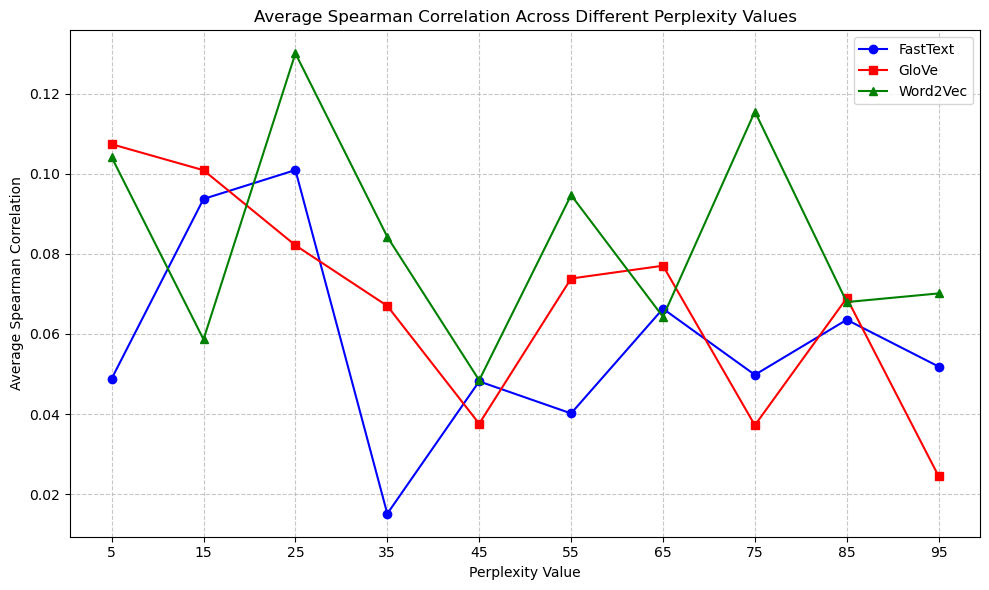

In [1]:
import matplotlib.pyplot as plt

# FastText correlations
fasttext_spearman_correlations_list1 = [0.0016, 0.0287, 0.0415, 0.1122, 0.0717, 0.0203, 0.0740, 0.0653, 0.1330, 0.0106]
fasttext_spearman_correlations_list2 = [0.0502, 0.0861, 0.0880, -0.0071, 0.0831, 0.1335, 0.0895, 0.1028, 0.0355, 0.0690]
fasttext_spearman_correlations_list3 = [0.0966, 0.0490, 0.1057, 0.0159, 0.0411, -0.0061, 0.1000, 0.0258, -0.0322, 0.1102]
fasttext_spearman_correlations_list4 = [0.0562, 0.1415, 0.1595, 0.0171, -0.0006, 0.0439, 0.0401, 0.0275, 0.1317, 0.0080]
fasttext_spearman_correlations_list5 = [0.0395, 0.1634, 0.1101, -0.0626, 0.0455, 0.0092, 0.0280, 0.0276, 0.0498, 0.0615]

# GloVe correlations
glove_spearman_correlations_list1 = [0.1138, 0.1660, 0.1300, 0.0948, 0.0385, 0.0945, 0.0933, 0.0049, -0.0277, 0.0338]
glove_spearman_correlations_list2 = [0.1399, 0.1507, 0.0298, 0.0412, 0.0276, 0.0796, 0.1047, 0.0358, 0.0874, 0.0374]
glove_spearman_correlations_list3 = [0.0640, 0.0542, 0.0876, -0.0006, 0.0504, 0.0535, 0.0478, 0.0674, 0.0959, 0.0013]
glove_spearman_correlations_list4 = [0.1305, 0.0565, 0.1173, 0.1112, 0.0273, 0.0873, 0.0821, 0.0622, 0.0953, 0.0228]
glove_spearman_correlations_list5 = [0.0889, 0.0772, 0.0461, 0.0885, 0.0441, 0.0544, 0.0574, 0.0157, 0.0940, 0.0270]

# Word2Vec correlations
word2vec_spearman_correlations_list1 = [0.1268, -0.0072, 0.1299, 0.1312, 0.0402, 0.0464, 0.1407, 0.1306, 0.1027, 0.0331]
word2vec_spearman_correlations_list2 = [0.1098, 0.0906, 0.1301, 0.0159, 0.0389, 0.1242, 0.1246, 0.1294, 0.0790, 0.0500]
word2vec_spearman_correlations_list3 = [0.0428, 0.0135, 0.1688, 0.0471, 0.0508, 0.1284, -0.0300, 0.0991, -0.0154, 0.0122]
word2vec_spearman_correlations_list4 = [0.0704, 0.1288, 0.0891, 0.1815, 0.0784, 0.0521, 0.0669, 0.0758, 0.0937, 0.1350]
word2vec_spearman_correlations_list5 = [0.1711, 0.0676, 0.1327, 0.0457, 0.0339, 0.1224, 0.0193, 0.1430, 0.0799, 0.1204]

# Group lists by model
fasttext_lists = [
    fasttext_spearman_correlations_list1,
    fasttext_spearman_correlations_list2,
    fasttext_spearman_correlations_list3,
    fasttext_spearman_correlations_list4,
    fasttext_spearman_correlations_list5,
]

glove_lists = [
    glove_spearman_correlations_list1,
    glove_spearman_correlations_list2,
    glove_spearman_correlations_list3,
    glove_spearman_correlations_list4,
    glove_spearman_correlations_list5,
]

word2vec_lists = [
    word2vec_spearman_correlations_list1,
    word2vec_spearman_correlations_list2,
    word2vec_spearman_correlations_list3,
    word2vec_spearman_correlations_list4,
    word2vec_spearman_correlations_list5,
]

# Function to calculate average correlations for each model
def calculate_averages(model_lists):
    # Calculate the average value for each index across all lists
    index_averages = []
    for i in range(len(model_lists[0])):
        index_values = [lst[i] for lst in model_lists]
        index_average = sum(index_values) / len(index_values)
        index_averages.append(index_average)
    return index_averages

# Calculate averages for each model
fasttext_averages = calculate_averages(fasttext_lists)
glove_averages = calculate_averages(glove_lists)
word2vec_averages = calculate_averages(word2vec_lists)

# Create a list of perplexity values from 5 to 95 with intervals of 10
perplexity_values = list(range(5, 96, 10))  # [5, 15, 25, ..., 85, 95]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each model with different colors
plt.plot(perplexity_values, fasttext_averages, marker='o', color='blue', label='FastText')
plt.plot(perplexity_values, glove_averages, marker='s', color='red', label='GloVe')
plt.plot(perplexity_values, word2vec_averages, marker='^', color='green', label='Word2Vec')

# Add labels and title
plt.xlabel("Perplexity Value")
plt.ylabel("Average Spearman Correlation")
plt.title("Average Spearman Correlation Across Different Perplexity Values")

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Customize the x-axis ticks
plt.xticks(perplexity_values)

# Add legend
plt.legend(loc='best')

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

[0.04882, 0.09374, 0.10096000000000001, 0.015099999999999999, 0.04816, 0.040159999999999994, 0.06632, 0.0498, 0.06356, 0.05186]
[0.10742, 0.10092000000000001, 0.08216000000000001, 0.06702, 0.037579999999999995, 0.07386000000000001, 0.07706, 0.0372, 0.06898, 0.02446]
[0.10418000000000001, 0.058660000000000004, 0.13012, 0.08428000000000001, 0.048440000000000004, 0.09469999999999999, 0.0643, 0.11557999999999999, 0.06798, 0.07014000000000001]


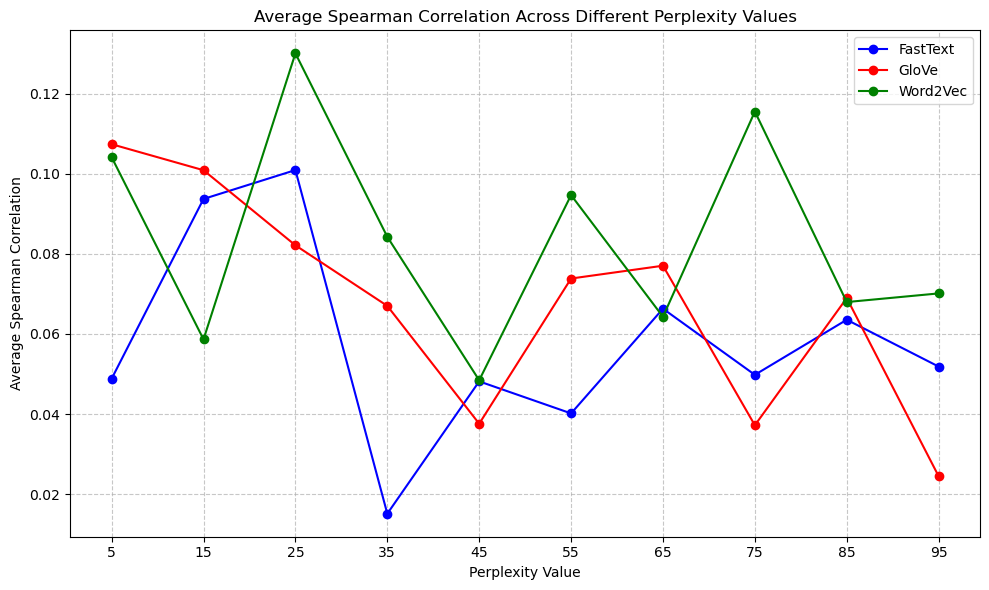

In [1]:
import matplotlib.pyplot as plt

# FastText correlations
fasttext_spearman_correlations_list1 = [0.0016, 0.0287, 0.0415, 0.1122, 0.0717, 0.0203, 0.0740, 0.0653, 0.1330, 0.0106]
fasttext_spearman_correlations_list2 = [0.0502, 0.0861, 0.0880, -0.0071, 0.0831, 0.1335, 0.0895, 0.1028, 0.0355, 0.0690]
fasttext_spearman_correlations_list3 = [0.0966, 0.0490, 0.1057, 0.0159, 0.0411, -0.0061, 0.1000, 0.0258, -0.0322, 0.1102]
fasttext_spearman_correlations_list4 = [0.0562, 0.1415, 0.1595, 0.0171, -0.0006, 0.0439, 0.0401, 0.0275, 0.1317, 0.0080]
fasttext_spearman_correlations_list5 = [0.0395, 0.1634, 0.1101, -0.0626, 0.0455, 0.0092, 0.0280, 0.0276, 0.0498, 0.0615]

# GloVe correlations
glove_spearman_correlations_list1 = [0.1138, 0.1660, 0.1300, 0.0948, 0.0385, 0.0945, 0.0933, 0.0049, -0.0277, 0.0338]
glove_spearman_correlations_list2 = [0.1399, 0.1507, 0.0298, 0.0412, 0.0276, 0.0796, 0.1047, 0.0358, 0.0874, 0.0374]
glove_spearman_correlations_list3 = [0.0640, 0.0542, 0.0876, -0.0006, 0.0504, 0.0535, 0.0478, 0.0674, 0.0959, 0.0013]
glove_spearman_correlations_list4 = [0.1305, 0.0565, 0.1173, 0.1112, 0.0273, 0.0873, 0.0821, 0.0622, 0.0953, 0.0228]
glove_spearman_correlations_list5 = [0.0889, 0.0772, 0.0461, 0.0885, 0.0441, 0.0544, 0.0574, 0.0157, 0.0940, 0.0270]

# Word2Vec correlations
word2vec_spearman_correlations_list1 = [0.1268, -0.0072, 0.1299, 0.1312, 0.0402, 0.0464, 0.1407, 0.1306, 0.1027, 0.0331]
word2vec_spearman_correlations_list2 = [0.1098, 0.0906, 0.1301, 0.0159, 0.0389, 0.1242, 0.1246, 0.1294, 0.0790, 0.0500]
word2vec_spearman_correlations_list3 = [0.0428, 0.0135, 0.1688, 0.0471, 0.0508, 0.1284, -0.0300, 0.0991, -0.0154, 0.0122]
word2vec_spearman_correlations_list4 = [0.0704, 0.1288, 0.0891, 0.1815, 0.0784, 0.0521, 0.0669, 0.0758, 0.0937, 0.1350]
word2vec_spearman_correlations_list5 = [0.1711, 0.0676, 0.1327, 0.0457, 0.0339, 0.1224, 0.0193, 0.1430, 0.0799, 0.1204]

# Group lists by model
fasttext_lists = [
    fasttext_spearman_correlations_list1,
    fasttext_spearman_correlations_list2,
    fasttext_spearman_correlations_list3,
    fasttext_spearman_correlations_list4,
    fasttext_spearman_correlations_list5,
]

glove_lists = [
    glove_spearman_correlations_list1,
    glove_spearman_correlations_list2,
    glove_spearman_correlations_list3,
    glove_spearman_correlations_list4,
    glove_spearman_correlations_list5,
]

word2vec_lists = [
    word2vec_spearman_correlations_list1,
    word2vec_spearman_correlations_list2,
    word2vec_spearman_correlations_list3,
    word2vec_spearman_correlations_list4,
    word2vec_spearman_correlations_list5,
]

# Function to calculate average correlations for each model
def calculate_averages(model_lists):
    # Calculate the average value for each index across all lists
    index_averages = []
    for i in range(len(model_lists[0])):
        index_values = [lst[i] for lst in model_lists]
        index_average = sum(index_values) / len(index_values)
        index_averages.append(index_average)
    return index_averages

# Calculate averages for each model
fasttext_averages = calculate_averages(fasttext_lists)
glove_averages = calculate_averages(glove_lists)
word2vec_averages = calculate_averages(word2vec_lists)

# Create a list of perplexity values from 5 to 95 with intervals of 10
perplexity_values = list(range(5, 96, 10))  # [5, 15, 25, ..., 85, 95]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each model with different colors
plt.plot(perplexity_values, fasttext_averages, marker='o', color='blue', label='FastText')
plt.plot(perplexity_values, glove_averages, marker='o', color='red', label='GloVe')
plt.plot(perplexity_values, word2vec_averages, marker='o', color='green', label='Word2Vec')
print(fasttext_averages)
print(glove_averages)
print(word2vec_averages)

# Add labels and title
plt.xlabel("Perplexity Value")
plt.ylabel("Average Spearman Correlation")
plt.title("Average Spearman Correlation Across Different Perplexity Values")

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Customize the x-axis ticks
plt.xticks(perplexity_values)

# Add legend
plt.legend(loc='best')

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

[0.04882, 0.09374, 0.10096000000000001, 0.015099999999999999, 0.04816, 0.040159999999999994, 0.06632, 0.0498, 0.06356, 0.05186]
[0.10742, 0.10092000000000001, 0.08216000000000001, 0.06702, 0.037579999999999995, 0.07386000000000001, 0.07706, 0.0372, 0.06898, 0.02446]
[0.10418000000000001, 0.058660000000000004, 0.13012, 0.08428000000000001, 0.048440000000000004, 0.09469999999999999, 0.0643, 0.11557999999999999, 0.06798, 0.07014000000000001]


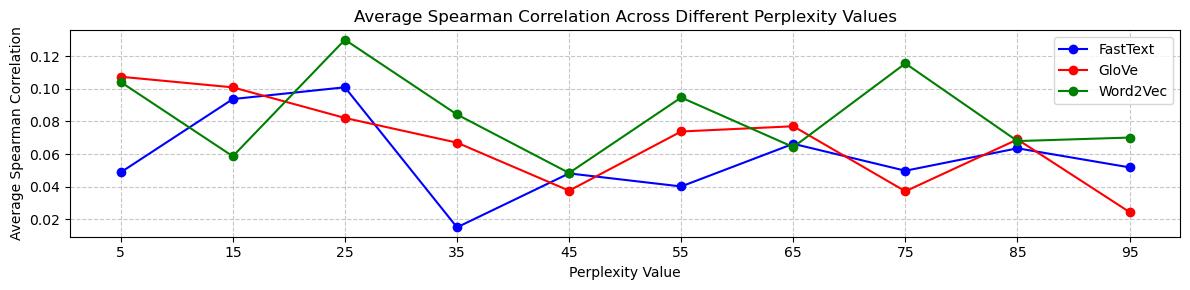

In [1]:
import matplotlib.pyplot as plt

# FastText correlations
fasttext_spearman_correlations_list1 = [0.0016, 0.0287, 0.0415, 0.1122, 0.0717, 0.0203, 0.0740, 0.0653, 0.1330, 0.0106]
fasttext_spearman_correlations_list2 = [0.0502, 0.0861, 0.0880, -0.0071, 0.0831, 0.1335, 0.0895, 0.1028, 0.0355, 0.0690]
fasttext_spearman_correlations_list3 = [0.0966, 0.0490, 0.1057, 0.0159, 0.0411, -0.0061, 0.1000, 0.0258, -0.0322, 0.1102]
fasttext_spearman_correlations_list4 = [0.0562, 0.1415, 0.1595, 0.0171, -0.0006, 0.0439, 0.0401, 0.0275, 0.1317, 0.0080]
fasttext_spearman_correlations_list5 = [0.0395, 0.1634, 0.1101, -0.0626, 0.0455, 0.0092, 0.0280, 0.0276, 0.0498, 0.0615]

# GloVe correlations
glove_spearman_correlations_list1 = [0.1138, 0.1660, 0.1300, 0.0948, 0.0385, 0.0945, 0.0933, 0.0049, -0.0277, 0.0338]
glove_spearman_correlations_list2 = [0.1399, 0.1507, 0.0298, 0.0412, 0.0276, 0.0796, 0.1047, 0.0358, 0.0874, 0.0374]
glove_spearman_correlations_list3 = [0.0640, 0.0542, 0.0876, -0.0006, 0.0504, 0.0535, 0.0478, 0.0674, 0.0959, 0.0013]
glove_spearman_correlations_list4 = [0.1305, 0.0565, 0.1173, 0.1112, 0.0273, 0.0873, 0.0821, 0.0622, 0.0953, 0.0228]
glove_spearman_correlations_list5 = [0.0889, 0.0772, 0.0461, 0.0885, 0.0441, 0.0544, 0.0574, 0.0157, 0.0940, 0.0270]

# Word2Vec correlations
word2vec_spearman_correlations_list1 = [0.1268, -0.0072, 0.1299, 0.1312, 0.0402, 0.0464, 0.1407, 0.1306, 0.1027, 0.0331]
word2vec_spearman_correlations_list2 = [0.1098, 0.0906, 0.1301, 0.0159, 0.0389, 0.1242, 0.1246, 0.1294, 0.0790, 0.0500]
word2vec_spearman_correlations_list3 = [0.0428, 0.0135, 0.1688, 0.0471, 0.0508, 0.1284, -0.0300, 0.0991, -0.0154, 0.0122]
word2vec_spearman_correlations_list4 = [0.0704, 0.1288, 0.0891, 0.1815, 0.0784, 0.0521, 0.0669, 0.0758, 0.0937, 0.1350]
word2vec_spearman_correlations_list5 = [0.1711, 0.0676, 0.1327, 0.0457, 0.0339, 0.1224, 0.0193, 0.1430, 0.0799, 0.1204]

# Group lists by model
fasttext_lists = [
    fasttext_spearman_correlations_list1,
    fasttext_spearman_correlations_list2,
    fasttext_spearman_correlations_list3,
    fasttext_spearman_correlations_list4,
    fasttext_spearman_correlations_list5,
]

glove_lists = [
    glove_spearman_correlations_list1,
    glove_spearman_correlations_list2,
    glove_spearman_correlations_list3,
    glove_spearman_correlations_list4,
    glove_spearman_correlations_list5,
]

word2vec_lists = [
    word2vec_spearman_correlations_list1,
    word2vec_spearman_correlations_list2,
    word2vec_spearman_correlations_list3,
    word2vec_spearman_correlations_list4,
    word2vec_spearman_correlations_list5,
]

# Function to calculate average correlations for each model
def calculate_averages(model_lists):
    # Calculate the average value for each index across all lists
    index_averages = []
    for i in range(len(model_lists[0])):
        index_values = [lst[i] for lst in model_lists]
        index_average = sum(index_values) / len(index_values)
        index_averages.append(index_average)
    return index_averages

# Calculate averages for each model
fasttext_averages = calculate_averages(fasttext_lists)
glove_averages = calculate_averages(glove_lists)
word2vec_averages = calculate_averages(word2vec_lists)

# Create a list of perplexity values from 5 to 95 with intervals of 10
perplexity_values = list(range(5, 96, 10))  # [5, 15, 25, ..., 85, 95]

# Create the plot
plt.figure(figsize=(12, 3))

# Plot each model with different colors
plt.plot(perplexity_values, fasttext_averages, marker='o', color='blue', label='FastText')
plt.plot(perplexity_values, glove_averages, marker='o', color='red', label='GloVe')
plt.plot(perplexity_values, word2vec_averages, marker='o', color='green', label='Word2Vec')
print(fasttext_averages)
print(glove_averages)
print(word2vec_averages)

# Add labels and title
plt.xlabel("Perplexity Value")
plt.ylabel("Average Spearman Correlation")
plt.title("Average Spearman Correlation Across Different Perplexity Values")

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Customize the x-axis ticks
plt.xticks(perplexity_values)

# Add legend
plt.legend(loc='best')

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()